In [1]:
import cvxpy as cp
from cvxpy import *
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

In [3]:
# see files without loading
sio.whosmat('Reg_signals.mat')

[('RegA_May04', (21601, 1), 'double'),
 ('RegA_May05', (21601, 1), 'double'),
 ('RegA_May06', (21601, 1), 'double'),
 ('RegA_May07', (21601, 1), 'double'),
 ('RegA_May08', (21601, 1), 'double'),
 ('RegA_May09', (21601, 1), 'double'),
 ('RegA_May10', (21601, 1), 'double'),
 ('RegD_May04', (21601, 1), 'double'),
 ('RegD_May05', (21601, 1), 'double'),
 ('RegD_May06', (21601, 1), 'double'),
 ('RegD_May07', (21601, 1), 'double'),
 ('RegD_May08', (21601, 1), 'double'),
 ('RegD_May09', (21601, 1), 'double'),
 ('RegD_May10', (21601, 1), 'double')]

In [4]:
regD_mat = sio.loadmat('Reg_signals.mat')

In [24]:
regD_ar = regD_mat["RegA_May04"]
type(regD_ar)
np.shape(regD_ar)

(21601, 1)

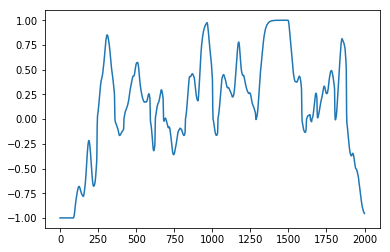

In [13]:
# plot regD
plt.plot(regD_ar[0:2000])
plt.show()

In [48]:
# mobile ESS parameters
E_max = 5
P_max = 5
E_init = 0
L = 0.02; # MW
lam_c = 50; # $/MWh
lam_mis = 5 # $/MWh
T = 240;
regD = regD_ar[0:T]
# T = np.shape(regD)[0]
#  define the subtraction matrix
Add_mat = np.tril(np.ones((T,T), dtype=int))

In [55]:
Bt = cp.Variable((T, 1))
epsilon = cp.Variable()
# ob = cp.Variable()
objective = cp.Minimize(epsilon)
# objective = cp.Minimize(np.max(np.dot(Sub_mat,Xt)))
# objective = cp.Minimize(np.max(np.multiply(Sub_mat,Xt)))
constraints = [abs(Bt-L*regD) <= epsilon,
               -P_max <= Bt,
               Bt <= P_max,
              Add_mat@Bt + E_init <= E_max,
              0*E_max <= Add_mat@Bt + E_init]

prob = cp.Problem(objective, constraints)
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
# print("optimal var", Bt.value)

status: optimal
optimal value 0.019999967014686235


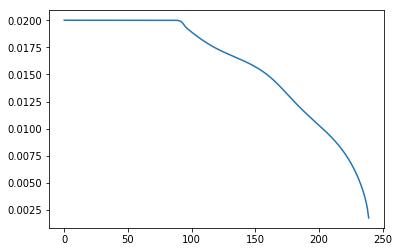

In [57]:
# plt.plot(L*regD)
plt.plot(Bt.value-L*regD)
plt.show()